# Config

**Import Library**
1. torch and torch.nn: For defining and training the neural network.
2. torch.optim: For optimization algorithms like Adam.
3. torch.utils.data: For handling datasets and DataLoaders.
4. pandas and numpy: For data manipulation.
5. sklearn: For preprocessing and splitting the dataset.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [5]:
if torch.cuda.is_available():
    print("GPU is available")
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("GPU is not available, using CPU")

GPU is available
Current device: 0
Device name: NVIDIA GeForce RTX 3060 Laptop GPU


In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Feature Extraction

In [8]:
# NF-UNSW-NB15-v2 dataset
data = pd.read_csv('./Dataset_DL/NF-UNSW-NB15-v2.csv')

In [9]:
len(data)

2390275

In [10]:
# keep only rows that contain "Benign" and "DoS" in the column "Attack"
values_to_keep = ['Benign', 'DoS']

# Filter the DataFrame
filtered_data_1 = data[data['Attack'].isin(values_to_keep)]

len(filtered_data_1)

2301016

In [11]:
# Keep only 12 features and 1 label from the dataset 
columns_to_keep = ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_SRC_PORT','L4_DST_PORT','PROTOCOL',
                   'IN_BYTES','OUT_BYTES', 'IN_PKTS','OUT_PKTS', 'FLOW_DURATION_MILLISECONDS', 'SRC_TO_DST_AVG_THROUGHPUT','DST_TO_SRC_AVG_THROUGHPUT',
                   'Label']

# Create a new DataFrame with only the specified columns
filtered_data_2 = filtered_data_1[columns_to_keep]

In [12]:
filtered_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2301016 entries, 0 to 2390274
Data columns (total 13 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   IPV4_SRC_ADDR               object
 1   IPV4_DST_ADDR               object
 2   L4_SRC_PORT                 int64 
 3   L4_DST_PORT                 int64 
 4   PROTOCOL                    int64 
 5   IN_BYTES                    int64 
 6   OUT_BYTES                   int64 
 7   IN_PKTS                     int64 
 8   OUT_PKTS                    int64 
 9   FLOW_DURATION_MILLISECONDS  int64 
 10  SRC_TO_DST_AVG_THROUGHPUT   int64 
 11  DST_TO_SRC_AVG_THROUGHPUT   int64 
 12  Label                       int64 
dtypes: int64(11), object(2)
memory usage: 245.8+ MB


In [13]:
# Checking missing values
missing_count = filtered_data_2.isnull().sum()
print(missing_count)

IPV4_SRC_ADDR                 0
IPV4_DST_ADDR                 0
L4_SRC_PORT                   0
L4_DST_PORT                   0
PROTOCOL                      0
IN_BYTES                      0
OUT_BYTES                     0
IN_PKTS                       0
OUT_PKTS                      0
FLOW_DURATION_MILLISECONDS    0
SRC_TO_DST_AVG_THROUGHPUT     0
DST_TO_SRC_AVG_THROUGHPUT     0
Label                         0
dtype: int64


In [14]:
# Create new features AVE_PKTS_LTH
# Use .loc to avoid SettingWithCopyWarning
# filtered_data_2.loc[:, 'packet_per_s'] = (filtered_data_2['IN_PKTS'] + filtered_data_2['OUT_PKTS']) / (filtered_data_2['FLOW_DURATION_MILLISECONDS'] / 1000)

filtered_data_2.loc[:, 'AVE_PKTS_LTH'] = (filtered_data_2['IN_BYTES'] + filtered_data_2['OUT_BYTES']) / (filtered_data_2['IN_PKTS'] + filtered_data_2['OUT_PKTS'])
filtered_data_2.loc[:, 'AVE_PKTS_LTH'] = filtered_data_2['AVE_PKTS_LTH'].round(2)


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20616\837102965.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data_2.loc[:, 'AVE_PKTS_LTH'] = (filtered_data_2['IN_BYTES'] + filtered_data_2['OUT_BYTES']) / (filtered_data_2['IN_PKTS'] + filtered_data_2['OUT_PKTS'])


In [15]:
# Create a Copy of the DataFrame to avoid SettingWithCopyWarning
filtered_data_2_copy = filtered_data_2.copy()

In [16]:
filtered_data_2_copy[['SRC_1', 'SRC_2', 'SRC_3', 'SRC_4']] = filtered_data_2_copy['IPV4_SRC_ADDR'].str.split('.', expand=True)

In [17]:
# Separate each ip address into 4 features
filtered_data_2_copy[['SRC_1', 'SRC_2', 'SRC_3', 'SRC_4']] = filtered_data_2_copy['IPV4_SRC_ADDR'].str.split('.', expand=True)
filtered_data_2_copy[['DST_1', 'DST_2', 'DST_3', 'DST_4']] = filtered_data_2_copy['IPV4_DST_ADDR'].str.split('.', expand=True)

# Convert the octets to integers 
filtered_data_2_copy[['SRC_1', 'SRC_2', 'SRC_3', 'SRC_4']] = filtered_data_2_copy[['SRC_1', 'SRC_2', 'SRC_3', 'SRC_4']].astype(int)
filtered_data_2_copy[['DST_1', 'DST_2', 'DST_3', 'DST_4']] = filtered_data_2_copy[['DST_1', 'DST_2', 'DST_3', 'DST_4']].astype(int)

In [18]:
# Remove several features
remove_columns = ['IPV4_SRC_ADDR','IPV4_DST_ADDR']

data_clean = filtered_data_2_copy.drop(columns = remove_columns)

data_clean

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,FLOW_DURATION_MILLISECONDS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,Label,AVE_PKTS_LTH,SRC_1,SRC_2,SRC_3,SRC_4,DST_1,DST_2,DST_3,DST_4
0,1305,21,6,9,193,1,3,0,3648000,3480000,0,50.50,59,166,0,5,149,171,126,8
1,1305,21,6,261,469,5,7,0,4656000,4584000,0,60.83,59,166,0,5,149,171,126,8
2,1305,21,6,481,750,9,11,0,5576000,5696000,0,61.55,59,166,0,5,149,171,126,8
3,1305,21,6,701,1054,13,15,0,6480000,6864000,0,62.68,59,166,0,5,149,171,126,8
4,1305,21,6,1031,1474,19,21,0,7544000,8240000,0,62.62,59,166,0,5,149,171,126,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2390270,58663,5190,6,1064,2364,12,14,0,8512000,18912000,0,131.85,59,166,0,4,149,171,126,1
2390271,60977,53,17,146,178,2,2,0,1168000,1424000,0,81.00,59,166,0,6,149,171,126,4
2390272,54553,80,6,994,8896,10,10,0,7952000,71168000,0,494.50,59,166,0,6,149,171,126,9
2390273,55026,8248,6,4014,60268,68,70,0,32112000,482144000,0,465.81,59,166,0,6,149,171,126,5


In [19]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2301016 entries, 0 to 2390274
Data columns (total 20 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   L4_SRC_PORT                 int64  
 1   L4_DST_PORT                 int64  
 2   PROTOCOL                    int64  
 3   IN_BYTES                    int64  
 4   OUT_BYTES                   int64  
 5   IN_PKTS                     int64  
 6   OUT_PKTS                    int64  
 7   FLOW_DURATION_MILLISECONDS  int64  
 8   SRC_TO_DST_AVG_THROUGHPUT   int64  
 9   DST_TO_SRC_AVG_THROUGHPUT   int64  
 10  Label                       int64  
 11  AVE_PKTS_LTH                float64
 12  SRC_1                       int64  
 13  SRC_2                       int64  
 14  SRC_3                       int64  
 15  SRC_4                       int64  
 16  DST_1                       int64  
 17  DST_2                       int64  
 18  DST_3                       int64  
 19  DST_4                     

# Hyper-parameters

Description for hyperparameter LSTM

In [22]:
# Define the size of the input layer (number of features in your CSV data)
input_size = 19  # Replace with the actual number of features

# Define the number of output classes for classification
num_classes = 2  # Replace with the number of classes in your dataset

# Define the batch size for training
batch_size = 64  # Adjust this based on your dataset size and memory constraints

# Define the number of epochs for training
num_epochs = 5  # Increase this if needed for better convergence

# Define the learning rate for the optimizer
learning_rate = 0.1  # Experiment with different values for optimal performance


# Load Dataset

In [24]:
# Extract features and labels
# Use the to_numpy() to convert data into Numpy array so it can be transform into tensor
X = data_clean.drop(columns=['Label']).to_numpy()  # Drop the target column
y = data_clean['Label'].to_numpy()
X

array([[1.3050e+03, 2.1000e+01, 6.0000e+00, ..., 1.7100e+02, 1.2600e+02,
        8.0000e+00],
       [1.3050e+03, 2.1000e+01, 6.0000e+00, ..., 1.7100e+02, 1.2600e+02,
        8.0000e+00],
       [1.3050e+03, 2.1000e+01, 6.0000e+00, ..., 1.7100e+02, 1.2600e+02,
        8.0000e+00],
       ...,
       [5.4553e+04, 8.0000e+01, 6.0000e+00, ..., 1.7100e+02, 1.2600e+02,
        9.0000e+00],
       [5.5026e+04, 8.2480e+03, 6.0000e+00, ..., 1.7100e+02, 1.2600e+02,
        5.0000e+00],
       [2.8987e+04, 2.6948e+04, 6.0000e+00, ..., 1.7100e+02, 1.2600e+02,
        6.0000e+00]])

**Split the dataset into:**
- Training set (X_train, y_train): 70%.
- Validation set (X_val, y_val): 15%.
- Test set (X_test, y_test): 15%.
- stratify=y ensures class distributions are preserved across splits.

In [26]:
# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [27]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1610711, 19)
y_train shape: (1610711,)


In [28]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

- TensorDataset wraps tensors into a dataset.
- DataLoader batches the data and optionally shuffles it.

In [30]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

# Model

**Multi-Layer Perceptron (MLP)**
- Fully connected layers and ReLU activation.
- Dropout is used to prevent overfitting.

In [33]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)    # Input Layer
        self.fc2 = nn.Linear(128, 64)           # First Hidden Layer
        self.fc3 = nn.Linear(64, num_classes)   # Output Layer
        self.relu = nn.ReLU()                   # Activation function
        self.dropout = nn.Dropout(0.3)          # Dropout for regularization

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

- input_dim: Number of input features.
- num_classes: Number of unique classes in the dataset.

In [35]:
model = MLP(input_dim=input_size, num_classes=num_classes).to(device)

# Loss Function and optimizer

- CrossEntropyLoss: Suitable for classification tasks.
- Adam: Optimization algorithm.

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training

- Training: Backpropagation and parameter updates using the training dataset.
- Validation: Evaluate on the validation set after each epoch to monitor progress.

In [49]:
# Training loop
def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    model.train()  # Set model to training mode
    history = {"train_loss": [], "val_loss": [], "val_rmse": [], "loss_percentage": []}
    
    for epoch in range(epochs):
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        squared_error = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
                
                # Calculate squared error for RMSE
                squared_error += ((predicted - y_batch) ** 2).sum().item()

        val_accuracy = correct / total
        val_rmse = (squared_error / total) ** 0.5  # Root Mean Square Error
        
        # Loss percentage: percentage change from previous epoch
        loss_percentage = (
            ((history["val_loss"][-1] - val_loss) / history["val_loss"][-1]) * 100
            if history["val_loss"]
            else 0
        )

        # Log metrics
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_rmse"].append(val_rmse)
        history["loss_percentage"].append(loss_percentage)

        print(
            f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Val RMSE: {val_rmse:.4f}, Loss Percentage: {loss_percentage:.2f}%, Val Accuracy: {val_accuracy:.4f}"
        )
        model.train()
    
    return history 

In [51]:
# Train the model
history = train(model, train_loader, val_loader, criterion, optimizer, epochs=num_epochs)

Epoch 1/5, Train Loss: 450.2393, Val Loss: 95.1777, Val RMSE: 0.0502, Loss Percentage: 0.00%, Val Accuracy: 0.9975
Epoch 2/5, Train Loss: 450.7910, Val Loss: 97.7337, Val RMSE: 0.0502, Loss Percentage: -2.69%, Val Accuracy: 0.9975
Epoch 3/5, Train Loss: 450.8173, Val Loss: 95.0902, Val RMSE: 0.0502, Loss Percentage: 2.70%, Val Accuracy: 0.9975
Epoch 4/5, Train Loss: 450.3905, Val Loss: 95.3225, Val RMSE: 0.0502, Loss Percentage: -0.24%, Val Accuracy: 0.9975
Epoch 5/5, Train Loss: 450.8152, Val Loss: 95.1297, Val RMSE: 0.0502, Loss Percentage: 0.20%, Val Accuracy: 0.9975


# Testing

In [53]:
# Evaluate on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy* 100:.2f}%")

Test Accuracy: 99.75%


# Result
**Performance Metrics: RMSE and Loss(%)**

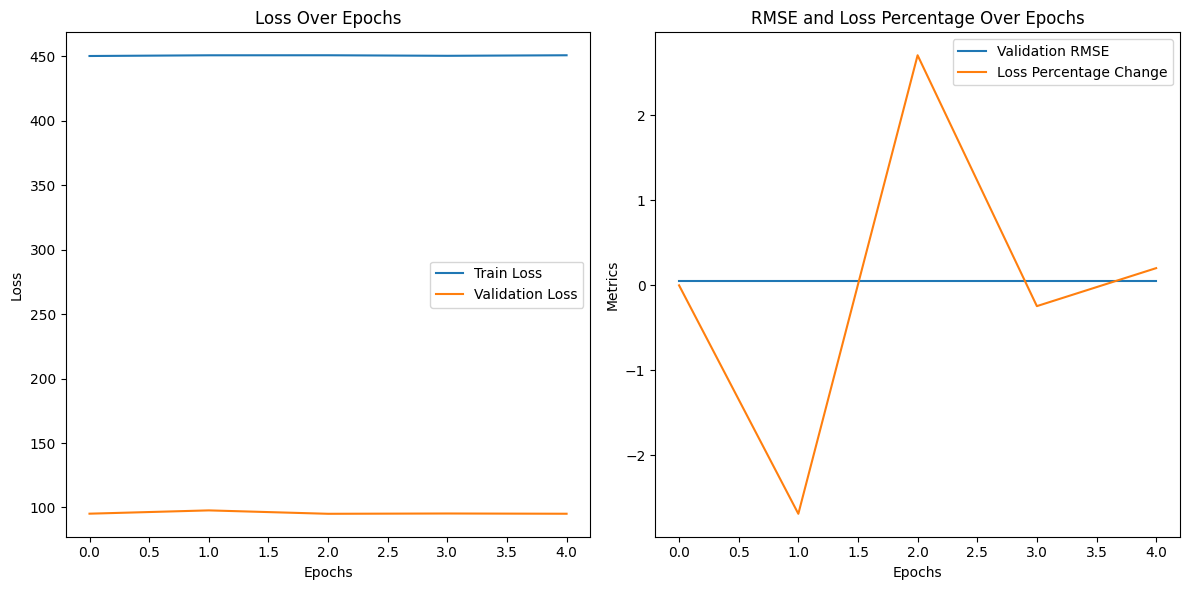

In [55]:
# Plot metrics
plt.figure(figsize=(12, 6))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# RMSE and Loss Percentage
plt.subplot(1, 2, 2)
plt.plot(history["val_rmse"], label="Validation RMSE")
plt.plot(history["loss_percentage"], label="Loss Percentage Change")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("RMSE and Loss Percentage Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [73]:
# Save the model
torch.save(model.state_dict(), r'.\Model\mlp_model.pth')

# Load the model (for inference)
loaded_model = MLP(input_dim=input_size, num_classes=num_classes)
# Use weights_only=True to avoid FutureWarning
loaded_model.load_state_dict(torch.load(r'.\Model\mlp_model.pth', weights_only=True))
loaded_model.to(device)
loaded_model.eval()

MLP(
  (fc1): Linear(in_features=19, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

# Serialization

In [131]:
import torch
import time
import pickle
import joblib
import os
import onnx
import onnxruntime as ort
from torch.utils.data import DataLoader

In [133]:
# Prepare a single batch of test data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
X_test_batch, _ = next(iter(test_loader))
X_test_batch = X_test_batch.to(device)

In [135]:
# Define paths for saving files
pickle_path = r'.\Model\mlp_model.pkl'
joblib_path = r'.\Model\mlp_model.joblib'
onnx_path = r'.\Model\mlp_model.onnx'
torch_path = r'.\Model\mlp_model.pt'

In [137]:
# Measure serialization for different formats
results = {}

In [139]:
# Save and load using Pickle
start = time.time()
with open(pickle_path, "wb") as f:
    pickle.dump(model, f)
save_time_pickle = time.time() - start

start = time.time()
with open(pickle_path, "rb") as f:
    model_pickle = pickle.load(f)
load_time_pickle = time.time() - start

pickle_file_size = os.path.getsize(pickle_path)

In [141]:
# Save and load using Joblib
start = time.time()
joblib.dump(model, joblib_path)
save_time_joblib = time.time() - start

start = time.time()
model_joblib = joblib.load(joblib_path)
load_time_joblib = time.time() - start

joblib_file_size = os.path.getsize(joblib_path)

In [143]:
# Save and load using ONNX
dummy_input = torch.randn(batch_size, X_test_batch.shape[1]).to(device)

start = time.time()
torch.onnx.export(
    model,
    dummy_input,  # Input tensor with fixed batch size
    onnx_path,  # Path to save the ONNX model
    input_names=["input"],
    output_names=["output"],
    export_params=True,
    opset_version=11  # Use a supported ONNX opset version
)
save_time_onnx = time.time() - start

onnx_file_size = os.path.getsize(onnx_path)

start = time.time()
session = ort.InferenceSession(onnx_path)
load_time_onnx = time.time() - start

In [145]:
# Save and load using PyTorch
start = time.time()
torch.save(model.state_dict(), torch_path)
save_time_torch = time.time() - start

start = time.time()
model_torch = MLP(input_dim=input_size, num_classes=num_classes)
model_torch.load_state_dict(torch.load(torch_path, weights_only=True))
model_torch.to(device)
load_time_torch = time.time() - start

torch_file_size = os.path.getsize(torch_path)

In [147]:
# Measure inference time
def measure_inference_time(model, X):
    model.eval()
    with torch.no_grad():
        start = time.time()
        for _ in range(100):  # Run inference 100 times to get average time
            model(X)
        end = time.time()
    return (end - start) / 100

In [149]:
# Inference time for Pickle and Joblib
inference_time_pickle = measure_inference_time(model_pickle, X_test_batch)
inference_time_joblib = measure_inference_time(model_joblib, X_test_batch)

In [151]:
def onnx_inference_fixed(session, X):
    assert X.size(0) == 64, "Input batch size must match the fixed batch size (64)"
    ort_inputs = {session.get_inputs()[0].name: X.cpu().numpy()}
    start = time.time()
    for _ in range(100):  # Run inference 100 times
        session.run(None, ort_inputs)
    end = time.time()
    return (end - start) / 100

In [153]:
inference_time_onnx = onnx_inference_fixed(session, X_test_batch)

In [155]:
# Inference time for PyTorch
inference_time_torch = measure_inference_time(model_torch, X_test_batch)

In [157]:
# Results summary
results["Pickle"] = {"save_time": save_time_pickle, "load_time": load_time_pickle, "file_size": pickle_file_size, "inference_time": inference_time_pickle}
results["Joblib"] = {"save_time": save_time_joblib, "load_time": load_time_joblib, "file_size": joblib_file_size, "inference_time": inference_time_joblib}
results["ONNX"] = {"save_time": save_time_onnx, "load_time": load_time_onnx, "file_size": onnx_file_size, "inference_time": inference_time_onnx}
results["PyTorch"] = {"save_time": save_time_torch, "load_time": load_time_torch, "file_size": torch_file_size, "inference_time": inference_time_torch}

# Print results
for method, metrics in results.items():
    print(f"--- {method} ---")
    print(f"Save Time: {metrics['save_time']:.6f} seconds")
    print(f"Load Time: {metrics['load_time']:.6f} seconds")
    print(f"File Size: {metrics['file_size'] / 1024:.2f} KB")
    print(f"Inference Time: {metrics['inference_time']:.6f} seconds")
    print()

--- Pickle ---
Save Time: 0.002641 seconds
Load Time: 0.010413 seconds
File Size: 45.94 KB
Inference Time: 0.000256 seconds

--- Joblib ---
Save Time: 0.005504 seconds
Load Time: 0.012559 seconds
File Size: 45.94 KB
Inference Time: 0.000264 seconds

--- ONNX ---
Save Time: 0.015293 seconds
Load Time: 0.012861 seconds
File Size: 43.46 KB
Inference Time: 0.000036 seconds

--- PyTorch ---
Save Time: 0.002491 seconds
Load Time: 0.016146 seconds
File Size: 45.40 KB
Inference Time: 0.000250 seconds

